In [1]:
from blimpy import Waterfall
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools, json
from astropy.stats.sigma_clipping import sigma_clip
from scipy.optimize import curve_fit
from scipy.interpolate import make_splrep
import scipy
from scipy import signal
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker

numexpr.utils   INFO     Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.


In [2]:
from blimpy import Waterfall

filename = 'Clipped.spliced_blc0001020304050607_guppi_57571_78180_HIP45653_0042.gpuspec.0002.h5'
fil = Waterfall(filename)

In [3]:
print(dir(fil))

['_Waterfall__load_data', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_blob_dimensions', '_get_chunk_dimensions', '_init_alternate', '_update_header', 'beam_axis', 'blank_dc', 'calc_n_coarse_chan', 'calibrate_band_pass_N1', 'container', 'data', 'ext', 'file_header', 'file_shape', 'file_size_bytes', 'filename', 'freq_axis', 'get_freqs', 'grab_data', 'header', 'info', 'logger', 'n_channels_in_file', 'n_ints_in_file', 'plot_all', 'plot_kurtosis', 'plot_spectrum', 'plot_spectrum_min_max', 'plot_time_series', 'plot_waterfall', 'read_data', 'selection_shape', 'stokes_axis', 'time_axis', 'write_to_fil', 'write_to_hdf5']


/home/long/anaconda3/lib/python3.12/site-packages/blimpy/utils.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


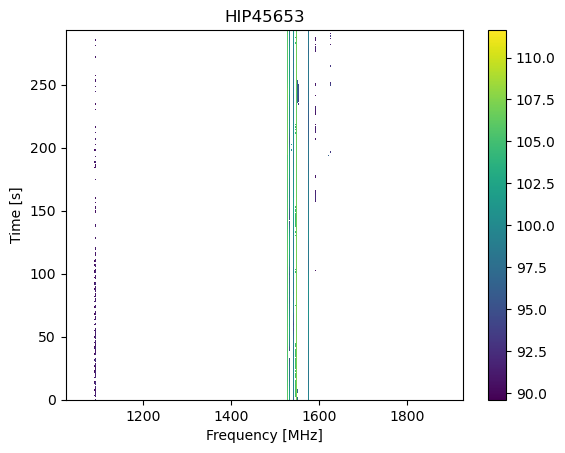

In [4]:
%matplotlib inline
fil.plot_waterfall()
plt.show()

In [5]:
freqs = np.array(fil.freqs)
data = np.array(fil.data)[:,0,:]
time = np.array(fil.timestamps)

print(freqs.shape, data.shape,time.shape)

(315392,) (273, 315392) (273,)


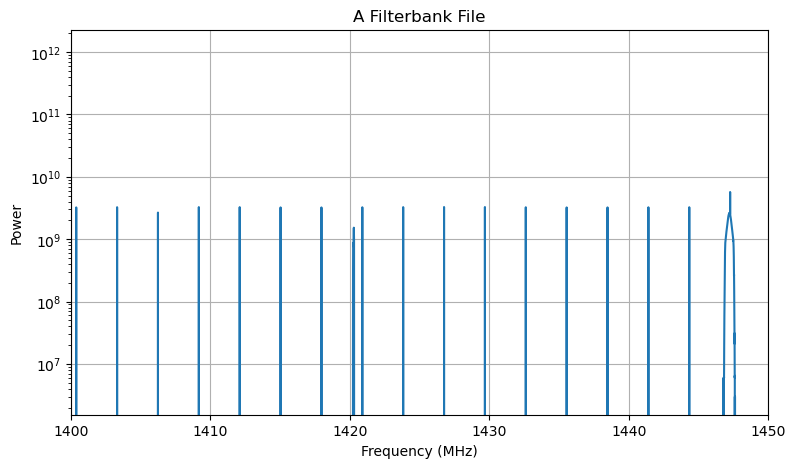

In [6]:
plt.figure(figsize=(9,5)) 
plt.plot(freqs, np.mean(data, axis = 0)) 
plt.yscale('log')
plt.xlim(1400,1450)
plt.grid()
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Power")
plt.title("A Filterbank File")
plt.show()

Here, we try to seperate signal and fitting a profile. The profile gonna be fitting using either Voigt profile or the delta delta function. The decision is made based on the linewidth, and should be make the fitting process faster

We will save the amplitude, central freq, sigma, and start, end freq. The amplitude will be save as Lorentz amplitude, Gaussian amplitude and total amplitude. 

For the case of delta delta, we will assign the Gaussian amplitude and Lorentz amplitude to be 0 and the total amplitude is the value which we measure. The sigma is also save as the minimum spectral resolution as these signals might be too small to be resolve properly 

These will be the features used for training SOM.

In [8]:
#list of data need for saving, 
dname = ['ampG','cen','sigmaG','ampL','sigmaL','amp','FWHM']

In [9]:
# Voigt profile fitting
def _1Voigt(x, ampG1, cen, sigmaG1, ampL1, widL1):
    return (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen)**2)/((2*sigmaG1)**2)))) +\
              ((ampL1*widL1**2/((x-cen)**2+widL1**2)))

def Gaussian(x, amp, cen, sigma):
    return amp*np.exp(-((x-cen)**2)/((2*sigma)**2))

def delta(x, cen, amp):
    res = np.abs(x[0]-x[1])/2
    return amp*(x <= (cen + res))*(x >= (cen - res))

In [10]:
out = pd.read_csv('outlier.csv')
dirac_plot = out
cen_dirac = np.array(dirac_plot['cen'])
dirac_amp = np.array(dirac_plot['ampL'])

In [ ]:
model = np.zeros_like(freqs)
for i in range(len(dirac_plot['ampL'])):
    model += delta(freqs, cen_dirac[i], dirac_amp[i])    

In [ ]:
plt.figure(figsize = (20, 7))
plt.scatter(freqs, model, c = 'r',label = 'dirac_profile')
plt.plot(freqs, np.mean(data, axis = 0), label = 'real signal')
plt.xlabel('freqs')
plt.legend()
plt.yscale('log')
plt.ylabel('Amplitude')
plt.xlim(1000,2000)
#plt.ylim(0,1e14)

plt.show()